1. Linear Regression

In [ ]:
import seaborn as sns
import sklearn.model_selection 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from sklearn import linear_model

In [2]:
 # loading dataset
mpg = sns.load_dataset("mpg")

# spit dataset
X, Y = mpg.drop(columns=["mpg"]), mpg["mpg"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size = 0.2, random_state = 231)

# combine training data for eda
train_df = X_train.copy()
train_df['mpg'] = y_train

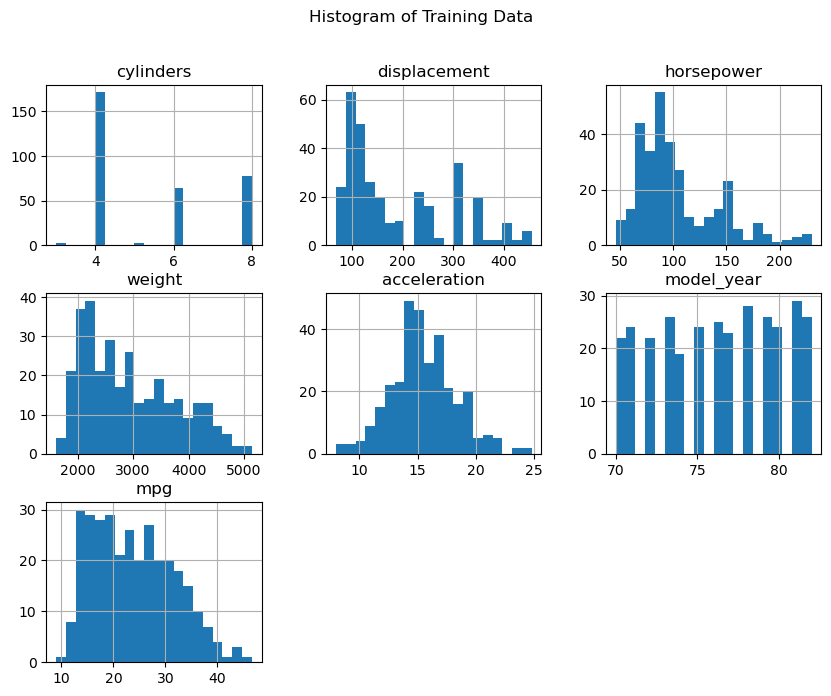

In [3]:
# histogram
train_df.hist(bins = 20, figsize = (10, 7.5))
plt.suptitle("Histogram of Training Data")
plt.show()

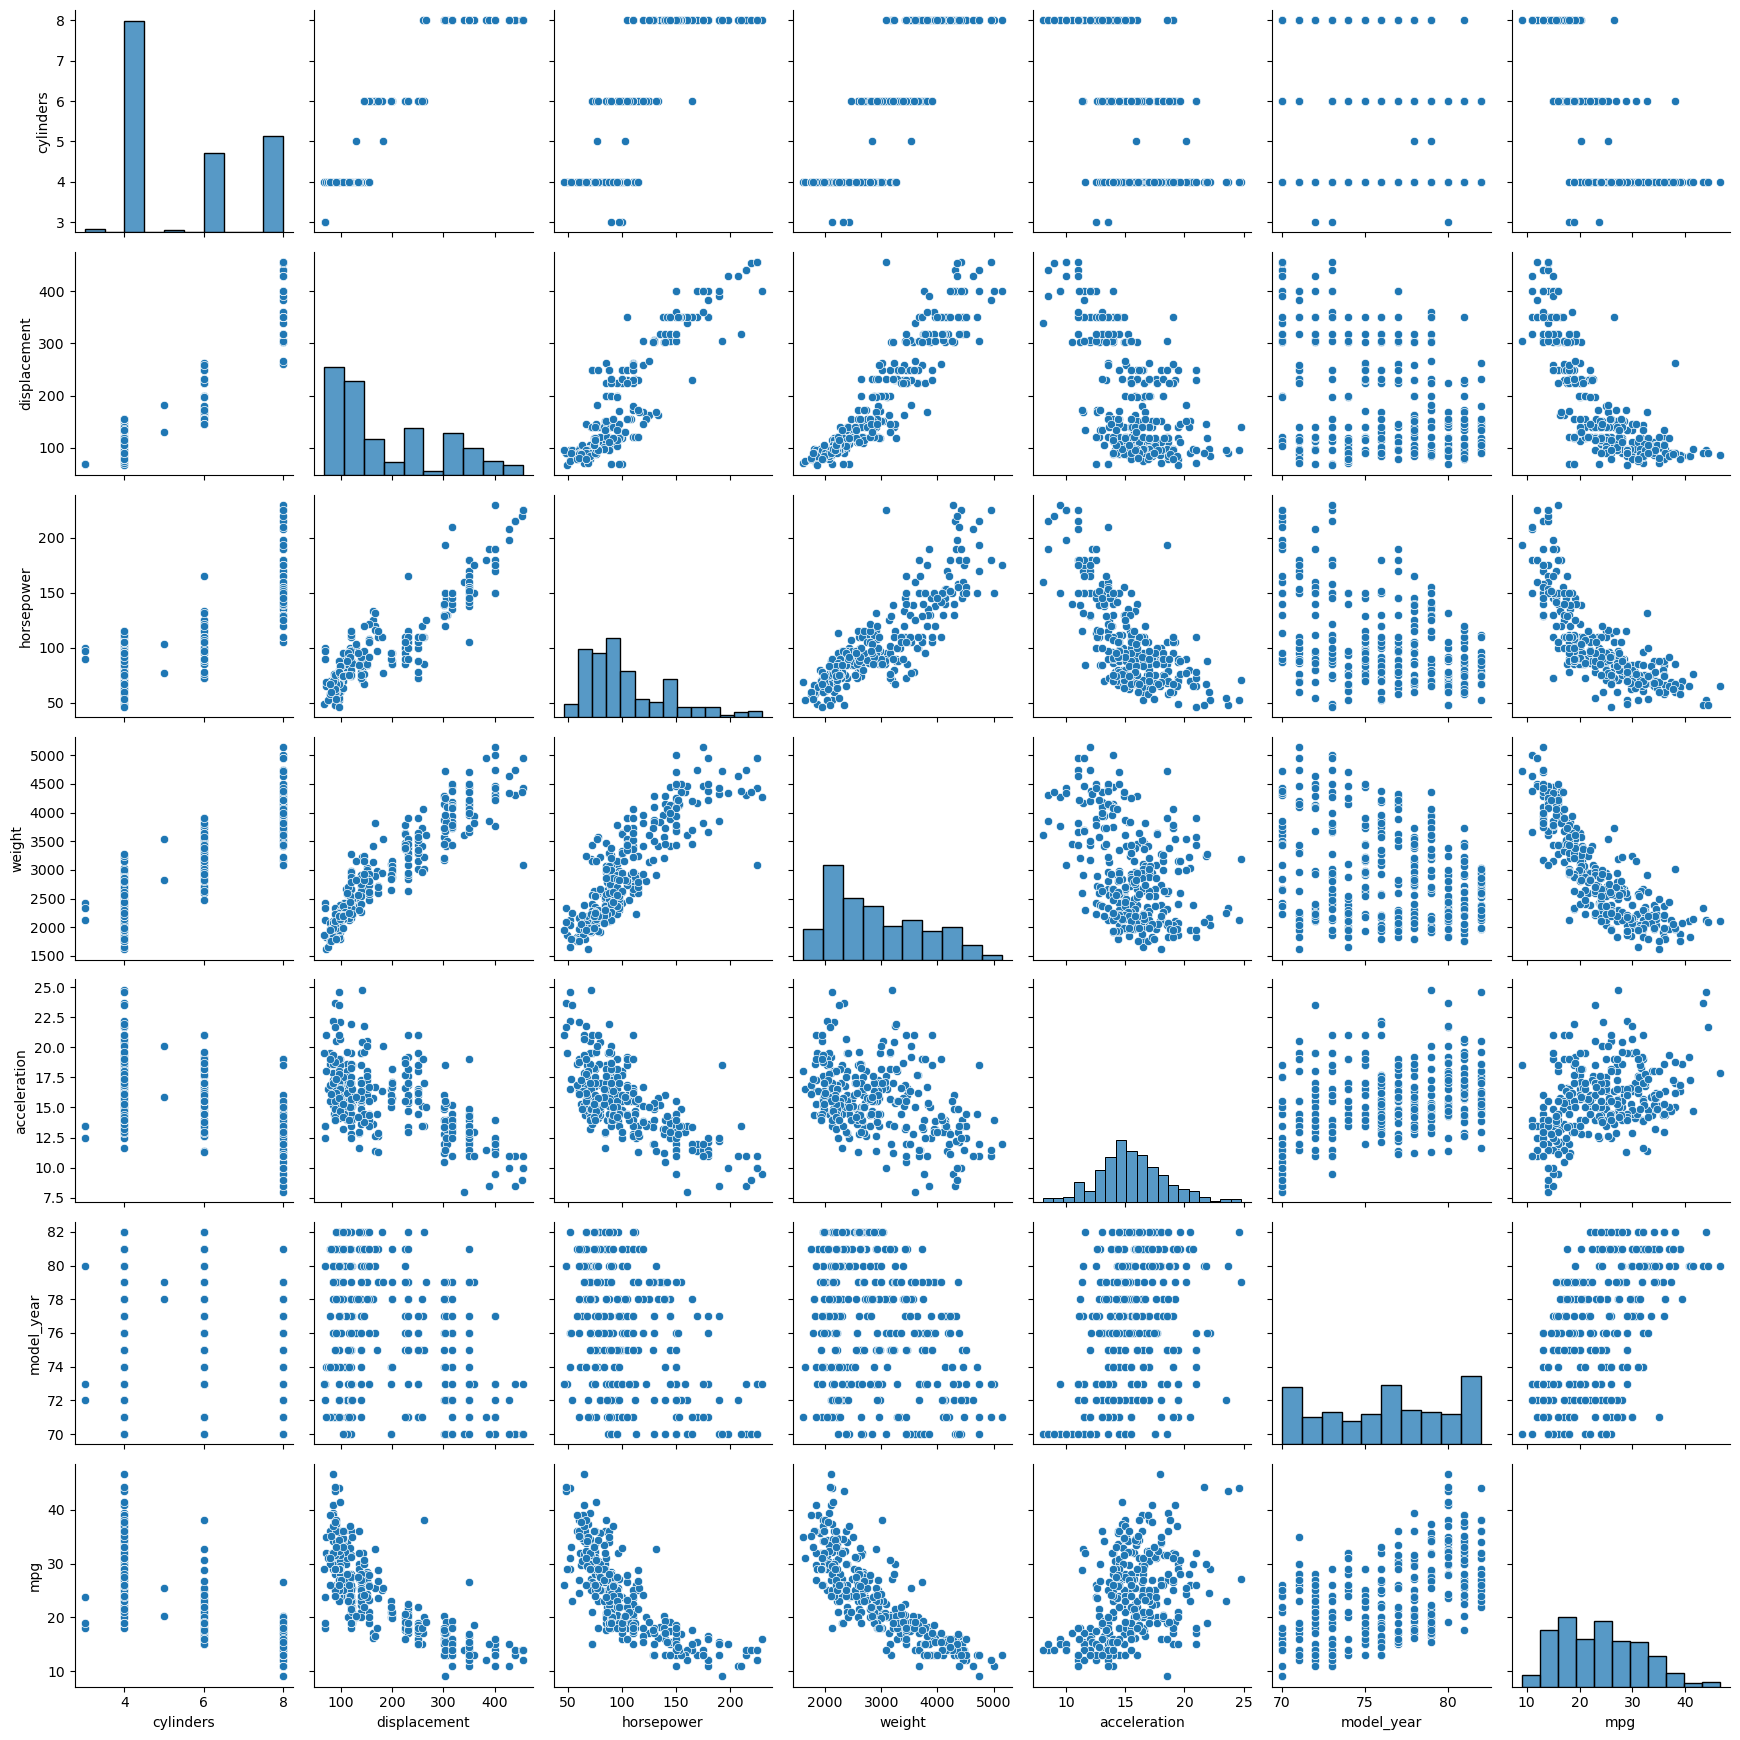

In [4]:
# scatterplots
sns.pairplot(train_df, kind = 'scatter')
plt.tight_layout()
plt.savefig("scatterplot1.png")
plt.show()

In [22]:
# Handling missing values
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

In [23]:
# dropping name for numerical cols
if 'name' in categorical_cols:
    X_train = X_train.drop(columns=['name'])
    X_test = X_test.drop(columns=['name'])
    categorical_cols.remove('name')

In [24]:
num_imputer = SimpleImputer(strategy='median')
X_train[numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = num_imputer.transform(X_test[numerical_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])

In [25]:
scaler = MinMaxScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


In [26]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

train_idx = X_train.index
test_idx = X_test.index

X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
X_test_encoded = encoder.transform(X_test[categorical_cols])

X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=train_idx)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=test_idx)

X_train_dropped = X_train.drop(columns=categorical_cols)
X_test_dropped = X_test.drop(columns=categorical_cols)

X_train_processed = pd.concat([X_train_dropped, X_train_encoded], axis=1)
X_test_processed = pd.concat([X_test_dropped, X_test_encoded], axis=1)

In [27]:
model = linear_model.LinearRegression()
model.fit(X_train_processed, y_train)

LinearRegression()

In [28]:
y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)


In [29]:
print("Coefficients: \n", model.coef_)

print("\nModel Performance:")
print(f"Training R-squared: {train_r2:.4f}")
print(f"Test R-squared: {test_r2:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")

Coefficients: 
 [ -3.09621958  10.98343266  -2.67601151 -25.39717502   1.9104146
   8.86697057   0.74679901   1.1235585   -1.87035751]

Model Performance:
Training R-squared: 0.8194
Test R-squared: 0.8339
Training MSE: 10.7770
Test MSE: 10.6361


2. Clustering

In [67]:
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples = 300, n_features = 4, centers = 3, random_state = 231)

In [75]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=231).fit(X_scaled)
    kmeans.cluster_centers_
    labels = kmeans.labels_
    sil_score = silhouette_score(X_scaled, labels)
    print(f"K = {k}, silhouette score = {sil_score:.4f}")

K = 2, silhouette score = 0.5685
K = 3, silhouette score = 0.8323
K = 4, silhouette score = 0.6573
K = 5, silhouette score = 0.6313


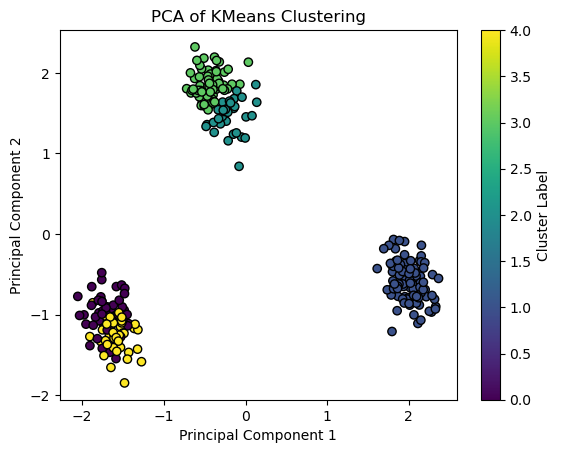

In [72]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, edgecolor = 'black')
plt.title("PCA of KMeans Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

In [80]:
from sklearn import cluster
from sklearn.cluster import AgglomerativeClustering

single = cluster.AgglomerativeClustering(
    linkage="single", compute_distances=True, n_clusters=None, distance_threshold=0
)
single.fit(X)

complete = cluster.AgglomerativeClustering(
    linkage="complete", compute_distances=True, n_clusters=None, distance_threshold=0
)
complete.fit(X)

average = cluster.AgglomerativeClustering(
    linkage="average", compute_distances=True, n_clusters=None, distance_threshold=0
)
average.fit(X)

AgglomerativeClustering(compute_distances=True, distance_threshold=0,
                        linkage='average', n_clusters=None)

In [81]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and then plot the dendrogram"""
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # create the linkage matrix
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

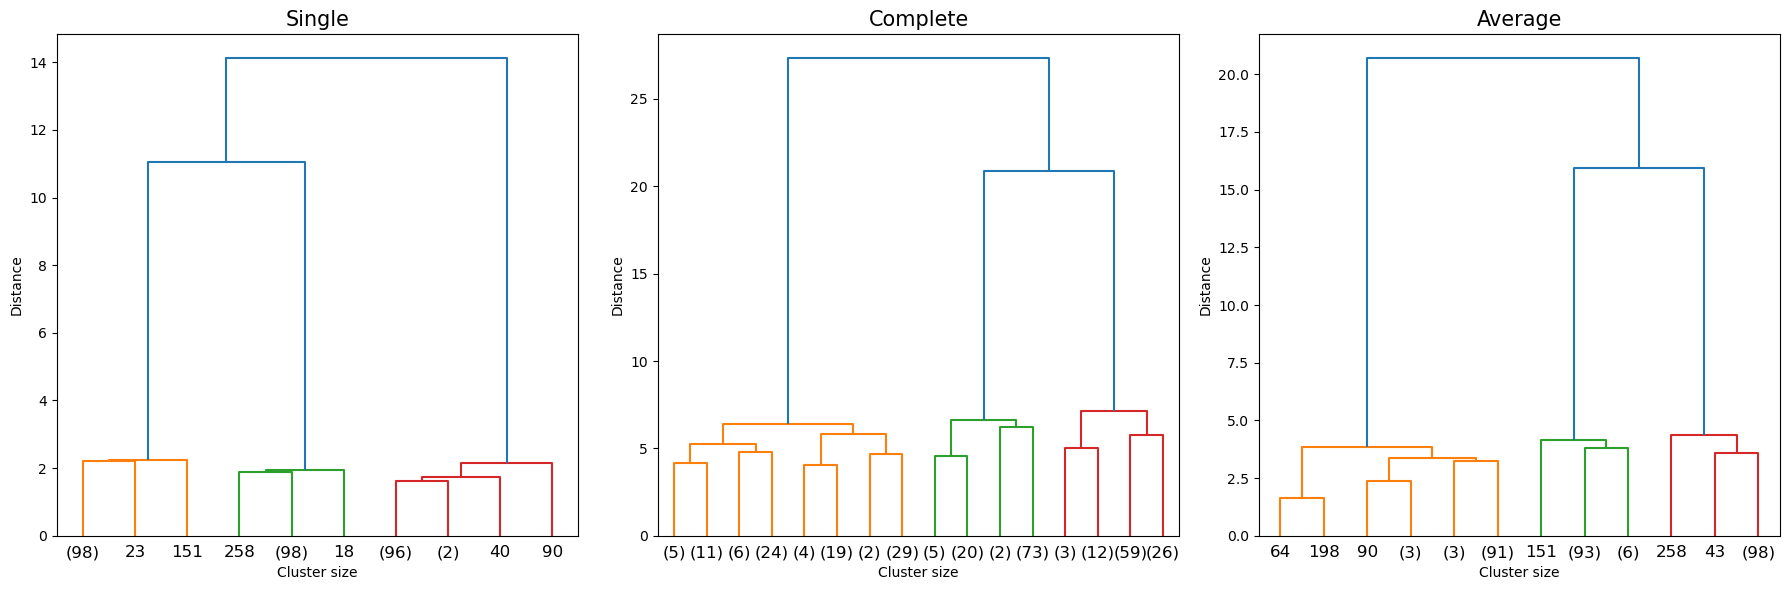

In [86]:
# plot dendrograms
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for i, model in enumerate([single, complete, average]):
    ax[i].set_title(f"{model.linkage}".capitalize(), fontsize=15)
    plot_dendrogram(model, ax=ax[i], truncate_mode="level", p=3)
    ax[i].set_xlabel("Cluster size")
    ax[i].set_ylabel("Distance")
plt.tight_layout()

3. Neural Networks


In [91]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# loading digits dataset
digits = load_digits()
X, y = digits.data, digits.target.astype(int)

# normalizing the data to [0, 1]
X = X / 16.0

# splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=231)

# standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test)

# create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
# ReLU activation function
import torch.nn as nn
import torch.nn.functional as F

# neural network class
class Network(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, output_size=10):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [97]:
# Sigmoid activation function
import torch.nn as nn
import torch.nn.functional as F

# neural network class
class Network(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, output_size=10):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [99]:
# Tanh activation function
import torch.nn as nn
import torch.nn.functional as F

# neural network class
class Network(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, output_size=10):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [100]:
import torch.optim as optim


model = Network()

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001) # default lr

num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc*100:.2f}%")

Epoch [1/15], Loss: 0.0664, Accuracy: 61.93%
Epoch [2/15], Loss: 0.0551, Accuracy: 86.43%
Epoch [3/15], Loss: 0.0507, Accuracy: 92.28%
Epoch [4/15], Loss: 0.0490, Accuracy: 95.34%
Epoch [5/15], Loss: 0.0481, Accuracy: 96.80%
Epoch [6/15], Loss: 0.0476, Accuracy: 97.49%
Epoch [7/15], Loss: 0.0473, Accuracy: 98.05%
Epoch [8/15], Loss: 0.0471, Accuracy: 98.05%
Epoch [9/15], Loss: 0.0469, Accuracy: 98.54%
Epoch [10/15], Loss: 0.0468, Accuracy: 98.82%
Epoch [11/15], Loss: 0.0466, Accuracy: 98.89%
Epoch [12/15], Loss: 0.0466, Accuracy: 99.03%
Epoch [13/15], Loss: 0.0465, Accuracy: 99.03%
Epoch [14/15], Loss: 0.0464, Accuracy: 99.03%
Epoch [15/15], Loss: 0.0464, Accuracy: 99.10%


In [106]:
model.eval()
correct = 0
total = 0
example_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
        # collect examples for display
        for i in range(len(y_batch)):
            if len(example_preds) < 5:
                example_preds.append((predicted[i].item(), y_batch[i].item()))

test_acc = correct / total
print(f"Test Accuracy: {test_acc*100:.2f}%\n")

for idx, (pred, actual) in enumerate(example_preds, 1):
    print(f"Test Image {idx}: Predicted Label = {pred}, Actual Label = {actual}")

Test Accuracy: 95.56%

Test Image 1: Predicted Label = 4, Actual Label = 4
Test Image 2: Predicted Label = 5, Actual Label = 5
Test Image 3: Predicted Label = 1, Actual Label = 1
Test Image 4: Predicted Label = 4, Actual Label = 4
Test Image 5: Predicted Label = 1, Actual Label = 1
